In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc

import torch
from torch.autograd import Variable

from plotting_utils import *
from numpy_utils import *
from torch_utils import *

from torch.optim import SGD, Adam
from cp_optimization import CPLoss

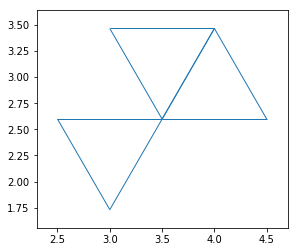

In [5]:
plot_polygon(tiled_triangle(2,3,0))
plot_polygon(tiled_triangle(2,3,1))
plot_polygon(tiled_triangle(2,3,3))
plt.gca().set_aspect('equal')

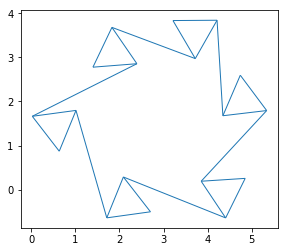

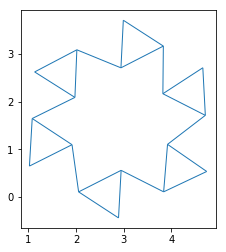

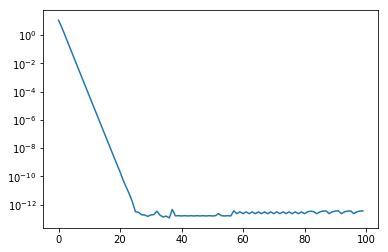

In [3]:
connections = np.array([ [[i, 0], [(i+1)%6, 1]] for i in range(6)])  # from poly 0, vertex 0 to poly 1, vertex 2
connection_lenghts = [1 for i in range(6)]
polys = [tiled_triangle(2, 2, i) for i in range(6)]
cp = CPLoss(polys, connections, connection_lenghts)

positions = Variable(torch.FloatTensor([(np.random.rand()+1) * U(i*pi/3) for i in range(6)]), requires_grad=True)
angles = Variable(torch.FloatTensor([np.random.rand()/5 for i in range(6)]), requires_grad=True)
tris = cp.mapped_points(positions, angles)
show_cp(tris, connections)

loss_curve = []
for i in range(100):
    optim = SGD([positions, angles], lr=.1, momentum=0)
    optim.zero_grad()
    loss = cp(positions, angles)
    loss.backward()
    optim.step()
    
    loss_curve.append(loss.data.numpy())

tris = cp.mapped_points(positions, angles)
show_cp(tris, connections)
plt.semilogy(loss_curve)
plt.show()

132 connections


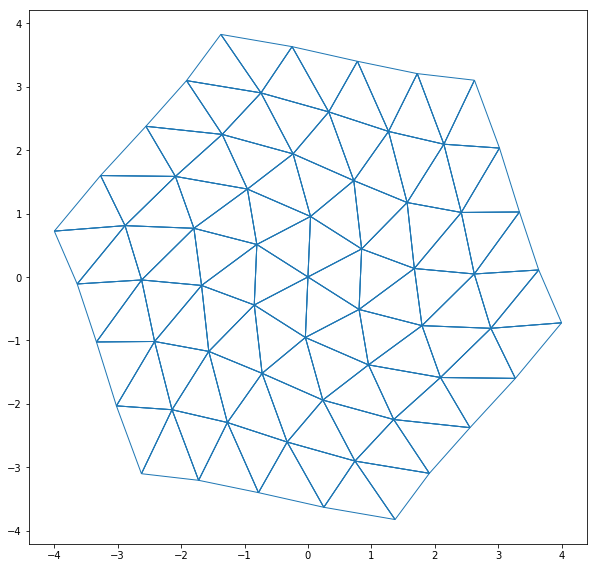

step 0, loss = 6.151333808898926


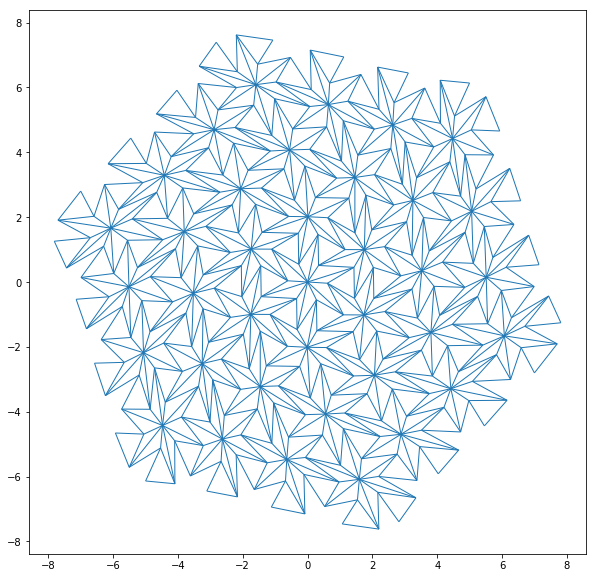

step 10000, loss = 0.0008057725499384105


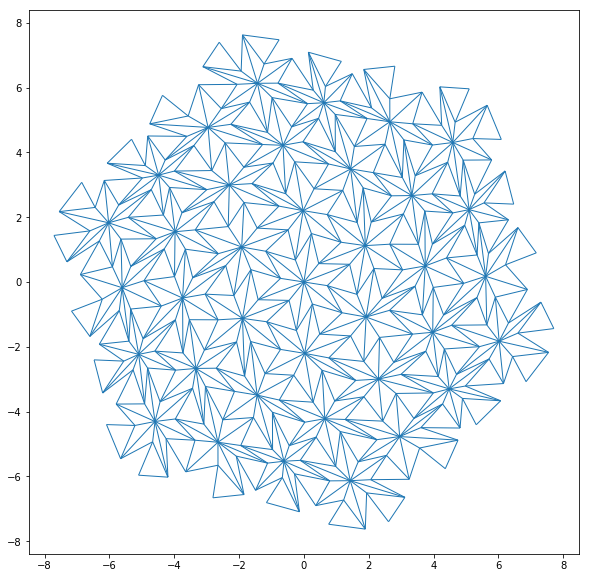

step 20000, loss = 0.0004002168425358832


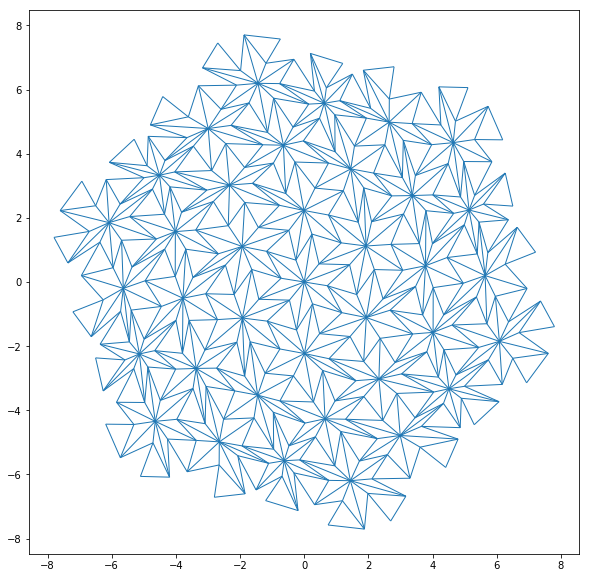

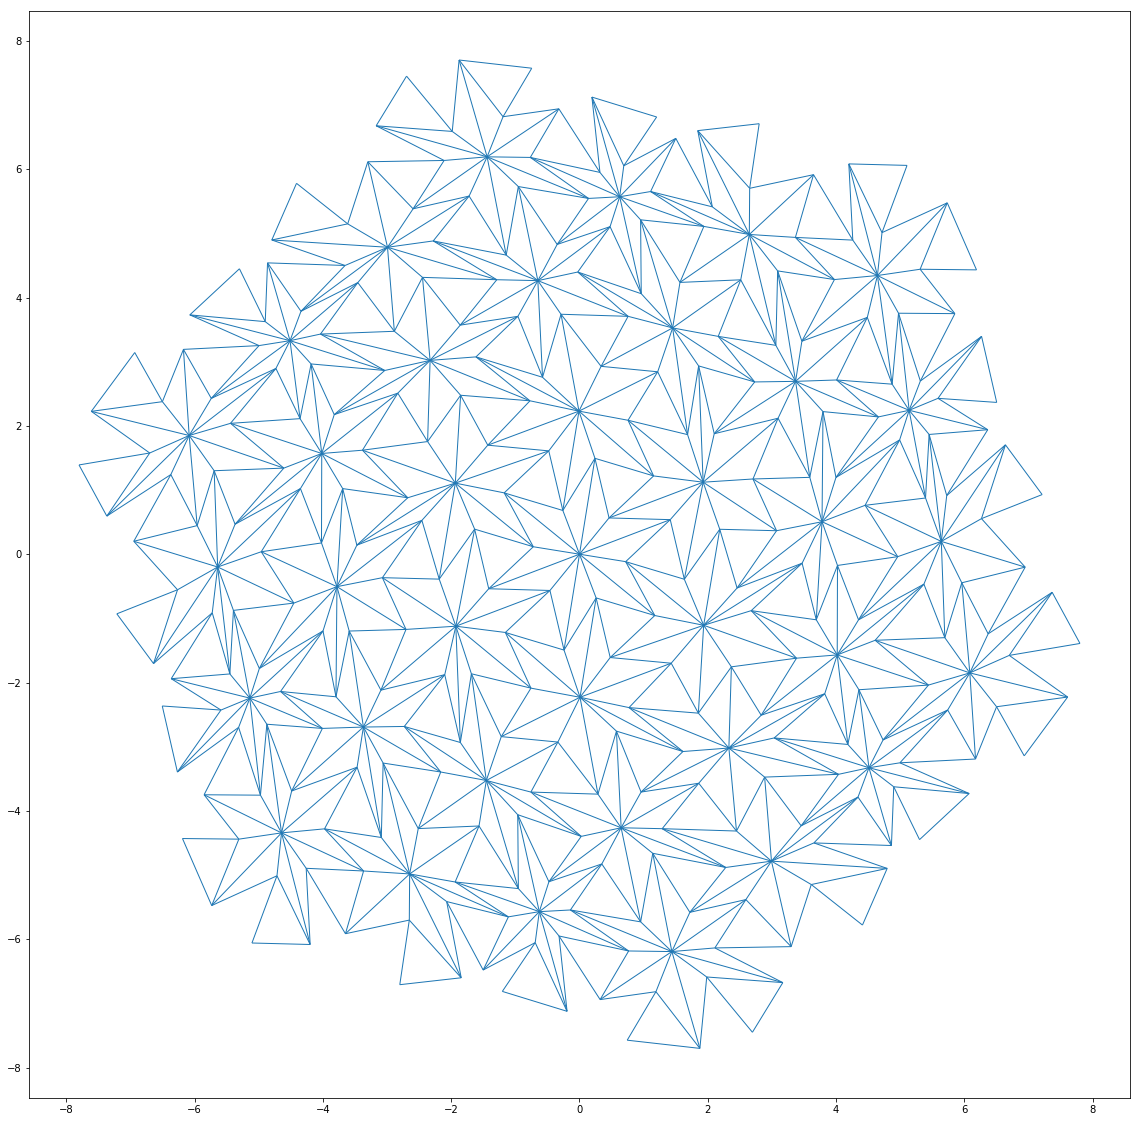

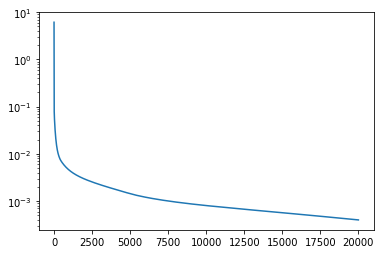

In [4]:
def map_poly(poly):
        dists = torch.sqrt((poly ** 2).sum(dim=-1))
        #return torch.stack([poly[:,0], poly[:,1] + .5*torch.sin(poly[:,0]/2)], dim=-1)
        return rotate_tensor(poly, 1.5*(torch.sigmoid(dists/2.0)-1)) * ((4.8 + torch.sigmoid(dists/2.-.7))/5.5)[:,None]
        #return poly * (2 - torch.sigmoid(dists/3 - 1))[:,None]

n = 4
k=10
tri_ids = np.array(
    [[i, j, 0] for i in range(-n, n) for j in range(-n, n) if abs(i+j+.5) <= n and j<k-1 and j>-k] +
    [[i+1, j+1, 3] for i in range(-n, n) for j in range(-n, n)  if abs(i+j+1.5) <= n and j<k-1 and j>-k], 
    dtype=np.int32)
n_polys = len(tri_ids)


# define connections
offsets = np.array([
    [1, 1, 3],
    [1, 0, 3],
    [0, 1, 3]
])
corners = np.array([
    [1, 1],
    [0, 0],
    [2, 2]
])
idx = np.stack(np.meshgrid(np.arange(n_polys), np.arange(n_polys)), axis=-1)
active = np.all(tri_ids[None, :, None ,:] == tri_ids[None, None, :, :] + offsets[:, None, None, :], axis=-1)
connections = np.stack([
    idx[None].repeat(len(offsets), axis=0)[active],
    corners[:, None, None].repeat(n_polys, axis=1).repeat(n_polys, axis=2)[active]
], axis=-1)
print(f'{len(connections)} connections')

# define polys that need circumcircles
circle_points = [ [
    [[i, j, 0], 1], 
    [[i+1, j, 3], 0],
    [[i+1, j-1, 0], 2],
    [[i+2, j, 3], 1],
    [[i+1, j, 0], 0],
    [[i+1, j+1, 3], 2]
] for i in range(-n, n-1) for j in range(-n+1, n) if abs(i+j+1) < n+1]
ids = np.array(list((np.array(circle_points)[:, :, 0]).flatten())).reshape(-1, 6, 3)
corners = np.array(list((np.array(circle_points)[:, :, 1]).flatten())).reshape(-1, 6)
circle_polys = []
for i, current in enumerate(ids):
    active = np.all(tri_ids[:, None, :] == current, axis=-1)
    if np.sum(active)==len(current):
        circle_polys.append(np.stack([np.argwhere(active.T)[:,1], corners[i]], axis=-1))
circle_polys = np.stack(circle_polys)


# init polys and cp object
polys = [torch.FloatTensor(tiled_triangle(*id)) for id in tri_ids]
#print(polys)
polys = [map_poly(poly) for poly in polys]
coms = torch.stack([poly.mean(dim=0) for poly in polys])
cp = CPLoss(polys, connections, circle_polys=circle_polys)
# init variables to be optimized
positions = Variable(0*torch.randn(coms.shape)/5 + 1.1*torch.FloatTensor(coms), requires_grad=True)
angles = Variable(torch.FloatTensor([0*np.random.rand()/10 for i in range(n_polys)]), requires_grad=True)
circle_centers = Variable(cp.initial_circle_centers(positions, angles), requires_grad=True)

zero_positions = Variable(0*torch.FloatTensor(coms), requires_grad=True)
tris = cp.mapped_points(zero_positions, angles)
plt.figure(figsize=(10, 10))
show_cp(tris, connections)
loss_curve = []
optim = SGD([positions, angles, circle_centers], lr=.1, momentum=.0)
for i in range(20001):
    optim.zero_grad()
    loss = cp(positions, angles, circle_centers)
    loss.backward()
    optim.step()
    
    loss_curve.append(loss.data.numpy())
    
    if i%10000 == 0:
        print(f'step {i}, loss = {loss.data.numpy()}')
        tris = cp.mapped_points(positions, angles)
        plt.figure(figsize=(10, 10))
        show_cp(tris, connections, centers=circle_centers.data.numpy(), center_connections=circle_polys)

tris = cp.mapped_points(positions, angles)
plt.figure(figsize=(20, 20))
show_cp(tris, connections, centers=circle_centers.data.numpy(), center_connections=circle_polys)
plt.semilogy(loss_curve)
plt.show()

310 connections


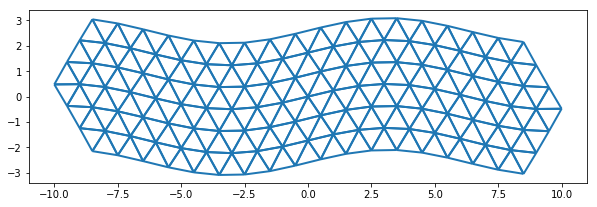

step 0, loss = 12.856494903564453


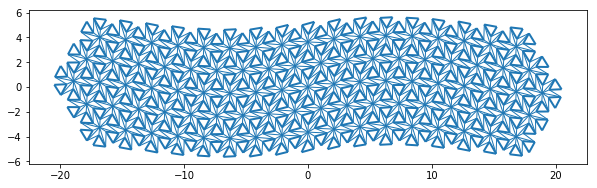

step 10000, loss = 1.0173443115490954e-05


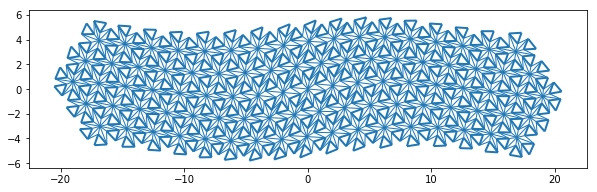

step 20000, loss = 1.4222708841771237e-06


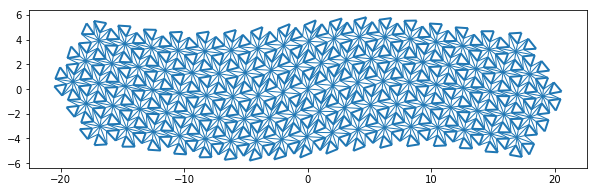

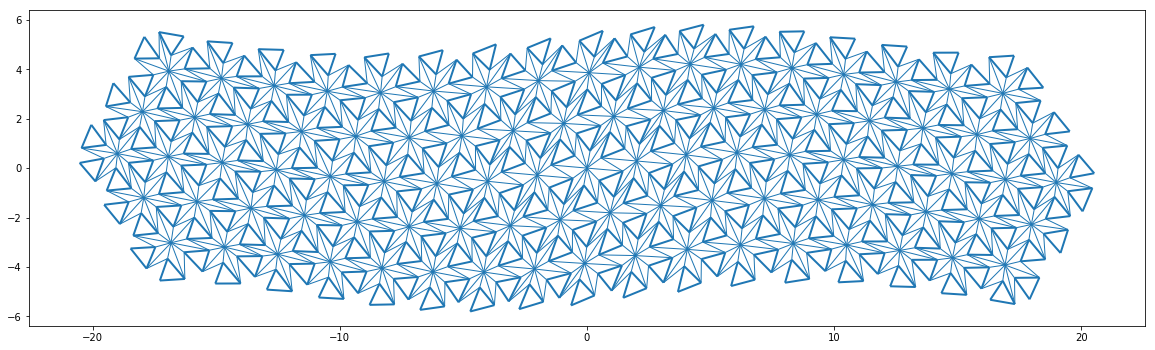

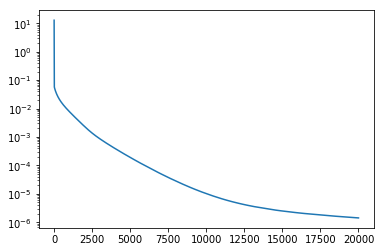

In [17]:
def map_poly(poly):
        dists = torch.sqrt((poly ** 2).sum(dim=-1))
        return torch.stack([poly[:,0], poly[:,1] + .5*torch.sin(poly[:,0]/2)], dim=-1)
        #return rotate_tensor(poly, 1.5*(torch.sigmoid(dists/2.0)-1)) # * ((4.8 - torch.sigmoid(dists/2.-.7))/4.5)[:,None]
        #return poly * (2 - torch.sigmoid(dists/3 - 1))[:,None]

n = 10
k=4
tri_ids = np.array(
    [[i, j, 0] for i in range(-n, n) for j in range(-n, n) if abs(i+j+.5) <= n and j<k-1 and j>-k] +
    [[i+1, j+1, 3] for i in range(-n, n) for j in range(-n, n)  if abs(i+j+1.5) <= n and j<k-1 and j>-k], 
    dtype=np.int32)
n_polys = len(tri_ids)


# define connections
offsets = np.array([
    [1, 1, 3],
    [1, 0, 3],
    [0, 1, 3]
])
corners = np.array([
    [1, 1],
    [0, 0],
    [2, 2]
])
idx = np.stack(np.meshgrid(np.arange(n_polys), np.arange(n_polys)), axis=-1)
active = np.all(tri_ids[None, :, None ,:] == tri_ids[None, None, :, :] + offsets[:, None, None, :], axis=-1)
connections = np.stack([
    idx[None].repeat(len(offsets), axis=0)[active],
    corners[:, None, None].repeat(n_polys, axis=1).repeat(n_polys, axis=2)[active]
], axis=-1)
print(f'{len(connections)} connections')

# define polys that need circumcircles
circle_points = [ [
    [[i, j, 0], 1], 
    [[i+1, j, 3], 0],
    [[i+1, j-1, 0], 2],
    [[i+2, j, 3], 1],
    [[i+1, j, 0], 0],
    [[i+1, j+1, 3], 2]
] for i in range(-n, n-1) for j in range(-n+1, n) if abs(i+j+1) < n+1]
ids = np.array(list((np.array(circle_points)[:, :, 0]).flatten())).reshape(-1, 6, 3)
corners = np.array(list((np.array(circle_points)[:, :, 1]).flatten())).reshape(-1, 6)
circle_polys = []
for i, current in enumerate(ids):
    active = np.all(tri_ids[:, None, :] == current, axis=-1)
    if np.sum(active)==len(current):
        circle_polys.append(np.stack([np.argwhere(active.T)[:,1], corners[i]], axis=-1))
circle_polys = np.stack(circle_polys)


# init polys and cp object
polys = [torch.FloatTensor(tiled_triangle(*id)) for id in tri_ids]
#print(polys)
coms = torch.stack([poly.mean(dim=0) for poly in polys])
polys = [map_poly(poly) for poly in polys]
cp = CPLoss(polys, connections, circle_polys=circle_polys)
# init variables to be optimized
positions = Variable(0*torch.randn(coms.shape)/5 + 1.1*torch.FloatTensor(coms), requires_grad=True)
angles = Variable(torch.FloatTensor([0*np.random.rand()/10 for i in range(n_polys)]), requires_grad=True)
circle_centers = Variable(cp.initial_circle_centers(positions, angles), requires_grad=True)

zero_positions = Variable(0*torch.FloatTensor(coms), requires_grad=True)
tris = cp.mapped_points(zero_positions, angles)
plt.figure(figsize=(10, 10))
show_cp(tris, connections)
loss_curve = []
optim = SGD([positions, angles, circle_centers], lr=.1, momentum=.0)
for i in range(20001):
    optim.zero_grad()
    loss = cp(positions, angles, circle_centers)
    loss.backward()
    optim.step()
    
    loss_curve.append(loss.data.numpy())
    
    if i%10000 == 0:
        print(f'step {i}, loss = {loss.data.numpy()}')
        tris = cp.mapped_points(positions, angles)
        plt.figure(figsize=(10, 10))
        show_cp(tris, connections, centers=circle_centers.data.numpy(), center_connections=circle_polys)

tris = cp.mapped_points(positions, angles)
plt.figure(figsize=(20, 20))
show_cp(tris, connections, centers=circle_centers.data.numpy(), center_connections=circle_polys)
plt.semilogy(loss_curve)
plt.show()

In [ ]:
tris = cp.mapped_points(positions, angles)
plt.figure(figsize=(20,20))
show_cp(tris, connections, centers=circle_centers.data.numpy(), center_connections=circle_polys)